In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import tensorflow as tf
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency
import scipy

import sys
sys.path.append('../../../..')
import mutagenesisfunctions as mf
from Bio import AlignIO
import time as time
import pandas as pd

In [3]:
'''SAVE PATHS AND PARAMETERS'''
params_results = '../../../results'
exp_folder = 'toypk'

modelarch = 'resbind'
trial = 't1'
modelsavename = '%s_%s'%(modelarch, trial)


In [4]:
'''OPEN DATA'''

starttime = time.time()

#Open data from h5py

data_path = '../../../data_toypk/toypk_50_d1.hdf5'
with h5py.File(data_path, 'r') as dataset:
    X_data = np.array(dataset['X_data'])
    Y_data = np.array(dataset['Y_data'])
    
numdata, seqlen, dims = X_data.shape
X_data = np.expand_dims(X_data, axis=2)
    
# get validation and test set from training set
test_frac = 0.3
valid_frac = 0.1
N = numdata
split_1 = int(N*(1-valid_frac-test_frac))
split_2 = int(N*(1-test_frac))
shuffle = np.random.permutation(N)

#set up dictionaries
train = {'inputs': X_data[shuffle[:split_1]], 
         'targets': Y_data[shuffle[:split_1]]}
valid = {'inputs': X_data[shuffle[split_1:split_2]], 
         'targets': Y_data[shuffle[split_1:split_2]]}
test = {'inputs': X_data[shuffle[split_2:]], 
         'targets': Y_data[shuffle[split_2:]]}
    
print ('Data extraction and dict construction completed in: ' + mf.sectotime(time.time() - starttime))


Data extraction and dict construction completed in: 0.31s


In [8]:
'''BUILD NEURAL NETWORK'''

def cnn_model(input_shape, output_shape):

    # create model
    layer1 = {'layer': 'input', #41
            'input_shape': input_shape
            }
    layer2 = {'layer': 'conv1d',
            'num_filters': 96,
            'filter_size': input_shape[1]-29,
            'norm': 'batch',
            'activation': 'relu',
            'dropout': 0.3,
            'padding': 'VALID',
            }
    layer3 = {'layer': 'conv1d_residual',
            'filter_size': 5,
            'function': 'relu',
            'dropout_block': 0.1,
            'dropout': 0.3,
            'mean_pool': 10,
            }
    
    layer4 = {'layer': 'dense',        # input, conv1d, dense, conv1d_residual, dense_residual, conv1d_transpose,
                                    # concat, embedding, variational_normal, variational_softmax, + more
          'num_units': 196,
          'norm': 'batch',          # if removed, automatically adds bias instead
          'activation': 'relu',     # or leaky_relu, prelu, sigmoid, tanh, etc
          'dropout': 0.5,           # if removed, default is no dropout
             }

    
    layer5 = {'layer': 'dense',
            'num_units': output_shape[1],
            'activation': 'sigmoid'
            }

    model_layers = [layer1, layer2, layer3, layer4, layer5]

    # optimization parameters
    optimization = {"objective": "binary",
                  "optimizer": "adam",
                  "learning_rate": 0.0003,
                  "l2": 1e-5,
                  #"label_smoothing": 0.05,
                  #"l1": 1e-6,
                  }
    return model_layers, optimization

tf.reset_default_graph()

# get shapes of inputs and targets
input_shape = list(train['inputs'].shape)
input_shape[0] = None
output_shape = train['targets'].shape

# load model parameters
model_layers, optimization = cnn_model(input_shape, output_shape)

# build neural network class
nnmodel = nn.NeuralNet(seed=247)
nnmodel.build_layers(model_layers, optimization)

# compile neural trainer
save_path = os.path.join(params_results, exp_folder)
param_path = os.path.join(save_path, modelsavename)
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=param_path)

In [5]:
'''TRAIN '''

# initialize session
sess = utils.initialize_session()

#Train the model

data = {'train': train, 'valid': valid}
fit.train_minibatch(sess, nntrainer, data, 
                    batch_size=100, 
                    num_epochs=100,
                    patience=40, 
                    verbose=2, 
                    shuffle=True, 
                    save_all=False)


sess.close()

Epoch 1 out of 100 
[==============================] 100.0% -- elapsed time=4.77s -- loss=0.69198 -- acc=58.710001%  
 
  valid loss:		0.52455
  valid accuracy:	0.75700+/-0.00000
  valid auc-roc:	0.85728+/-0.00000
  valid auc-pr:		0.84556+/-0.00000
  lower cross-validation found
  saving model to:  ../../../results/toypk/resbind_t1_best.ckpt
Epoch 2 out of 100 
[==============================] 100.0% -- elapsed time=4.41s -- loss=0.50309 -- acc=75.380008%  
 
  valid loss:		0.27877
  valid accuracy:	0.90700+/-0.00000
  valid auc-roc:	0.96904+/-0.00000
  valid auc-pr:		0.96267+/-0.00000
  lower cross-validation found
  saving model to:  ../../../results/toypk/resbind_t1_best.ckpt
Epoch 3 out of 100 
[==============================] 100.0% -- elapsed time=4.42s -- loss=0.35115 -- acc=85.093339%  
 
  valid loss:		0.18642
  valid accuracy:	0.93410+/-0.00000
  valid auc-roc:	0.98894+/-0.00000
  valid auc-pr:		0.98641+/-0.00000
  lower cross-validation found
  saving model to:  ../../../res

In [9]:
'''TEST'''
sess = utils.initialize_session()

# set best parameters
nntrainer.set_best_parameters(sess)

# test model
loss, mean_vals, std_vals = nntrainer.test_model(sess, test, name='test')

loading model from:  ../../../results/toypk/resbind_t1_best.ckpt
INFO:tensorflow:Restoring parameters from ../../../results/toypk/resbind_t1_best.ckpt
  test  loss:		0.08183
  test  accuracy:	0.97683+/-0.00000
  test  auc-roc:	0.99809+/-0.00000
  test  auc-pr:		0.99741+/-0.00000


In [11]:
'''SORT ACTIVATIONS'''

predictionsoutput = nntrainer.get_activations(sess, test, layer='output')
plot_index = np.argsort(predictionsoutput[:,0])[::-1]

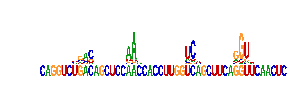

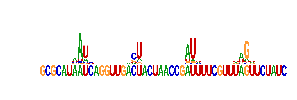

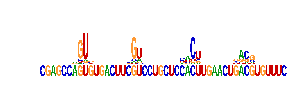

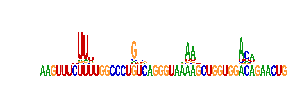

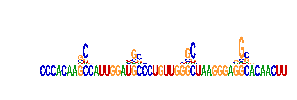

In [27]:
'''FIRST ORDER MUTAGENESIS'''
#num_plots=np.linspace(0,20000,5).astype(int)
num_plots = range(5)
for ii in num_plots: 

    X = np.expand_dims(test['inputs'][plot_index[10000+ii]], axis=0)
    
    mf.fom_saliency(X, layer='dense_1_bias', alphabet='rna', nntrainer=nntrainer, sess=sess, figsize=(15,1.5))

In [7]:
'''SECOND ORDER MUTAGENESIS'''

num_summary = 2000

arrayspath = 'Arrays/%s_%s_so%.0fk.npy'%(exp_folder, modelarch, num_summary/1000)
X = test['inputs'][plot_index[:num_summary]]

mean_mut2 = mf.som_average_ungapped_logodds(X, range(seqlen), arrayspath, nntrainer, sess, progress='on', 
                                           save=True, layer='dense_1_bias')

0


../../../../mutagenesisfunctions.py:554: RuntimeWarning: invalid value encountered in log
  mut2_scores = np.log(mut2_scores + 1e-7) - np.log(WT_score+1e-7)


Epoch duration =0.63s
Cumulative duration =0.63s

1
Epoch duration =0.54s
Cumulative duration =1.16s

2
Epoch duration =0.54s
Cumulative duration =1.7s

3
Epoch duration =0.53s
Cumulative duration =2.24s

4
Epoch duration =0.54s
Cumulative duration =2.78s

5
Epoch duration =0.53s
Cumulative duration =3.31s

6
Epoch duration =0.54s
Cumulative duration =3.85s

7
Epoch duration =0.66s
Cumulative duration =4.51s

8
Epoch duration =0.53s
Cumulative duration =5.04s

9
Epoch duration =0.53s
Cumulative duration =5.57s

10
Epoch duration =0.53s
Cumulative duration =6.1s

11
Epoch duration =0.53s
Cumulative duration =6.63s

12
Epoch duration =0.54s
Cumulative duration =7.17s

13
Epoch duration =0.53s
Cumulative duration =7.7s

14
Epoch duration =0.53s
Cumulative duration =8.23s

15
Epoch duration =0.52s
Cumulative duration =8.75s

16
Epoch duration =0.52s
Cumulative duration =9.27s

17
Epoch duration =0.53s
Cumulative duration =9.8s

18
Epoch duration =0.52s
Cumulative duration =10.33s

19
Epoch

In [19]:
#Load the saved data
num_summary = 2000
arrayspath = 'Arrays/%s_%s_so%.0fk.npy'%(exp_folder, modelarch, num_summary/1000)
mean_mut2 = np.load(arrayspath)

#average the values
#mean_mut2 = sum_mut2/num_summary

#Reshape into a holistic tensor organizing the mutations into 4*4
meanhol_mut2 = mean_mut2.reshape(seqlen,seqlen,4,4)

#Normalize
normalize = True
if normalize:
    meanhol_mut2 = mf.normalize_mut_hol(meanhol_mut2, nntrainer, sess, normfactor=1)

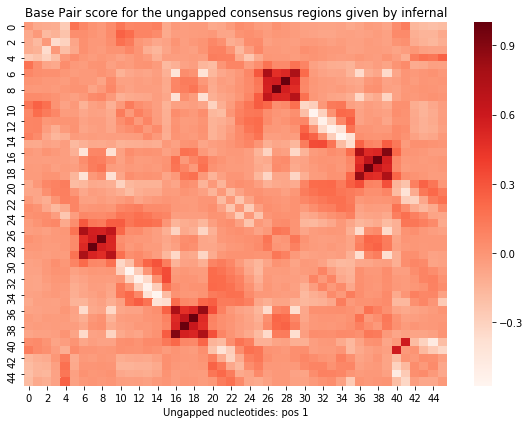

In [20]:
#Let's try something weird
bpfilter = np.ones((4,4))*-1
for i,j in zip(range(4), range(4)):
    bpfilter[i, -(j+1)] = 1.
    
C = np.sum((meanhol_mut2*bpfilter).reshape(seqlen,seqlen,dims*dims), axis=2)
C = C - np.mean(C)
C = C/np.max(C)

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sb.heatmap(C,vmin=None, cmap='Reds', linewidth=0.0)
plt.title('Base Pair score for the ungapped consensus regions given by infernal')
plt.xlabel('Ungapped nucleotides: pos 1')


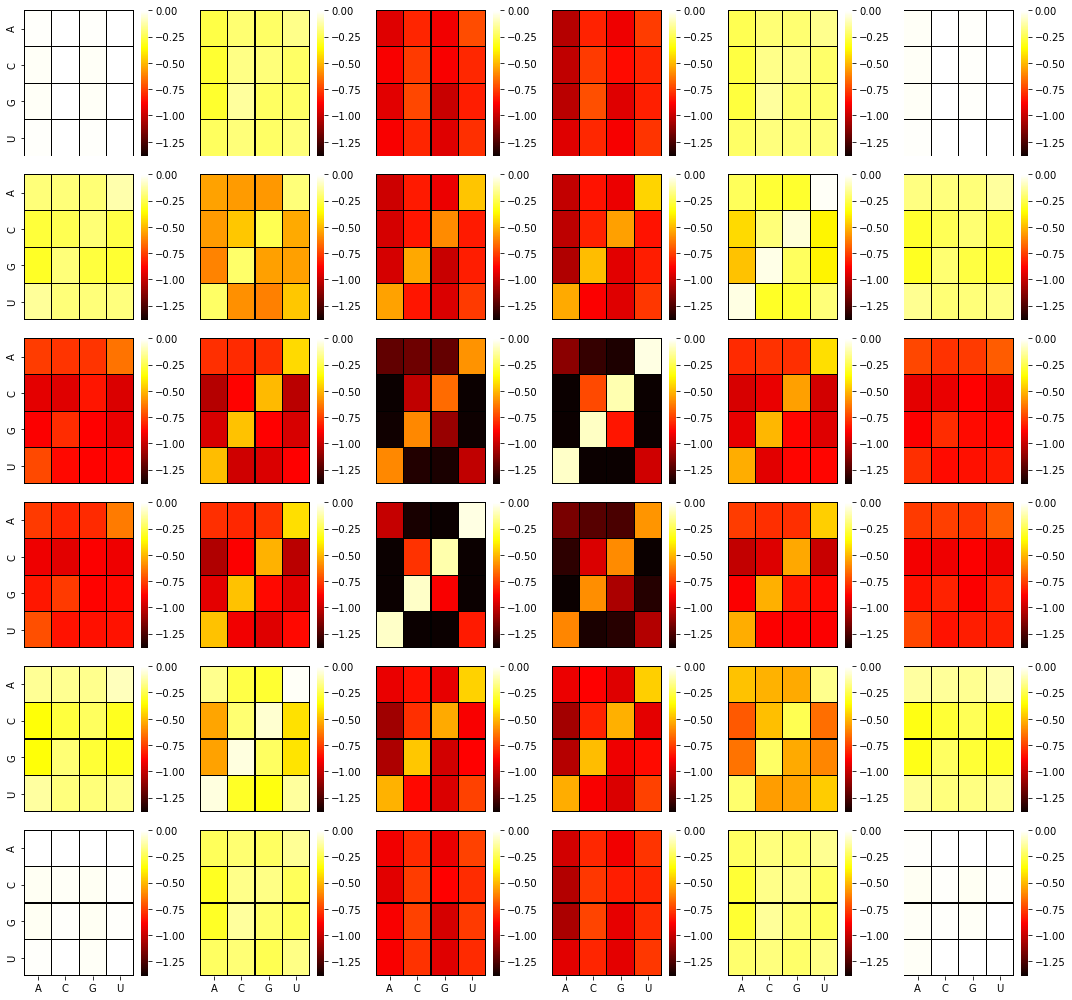

In [40]:
mf.square_holplot(meanhol_mut2, num=6, alphabet='rna', start=(5,25), cbar=True, cmap='hot', limits=(np.log(0.25),0.))

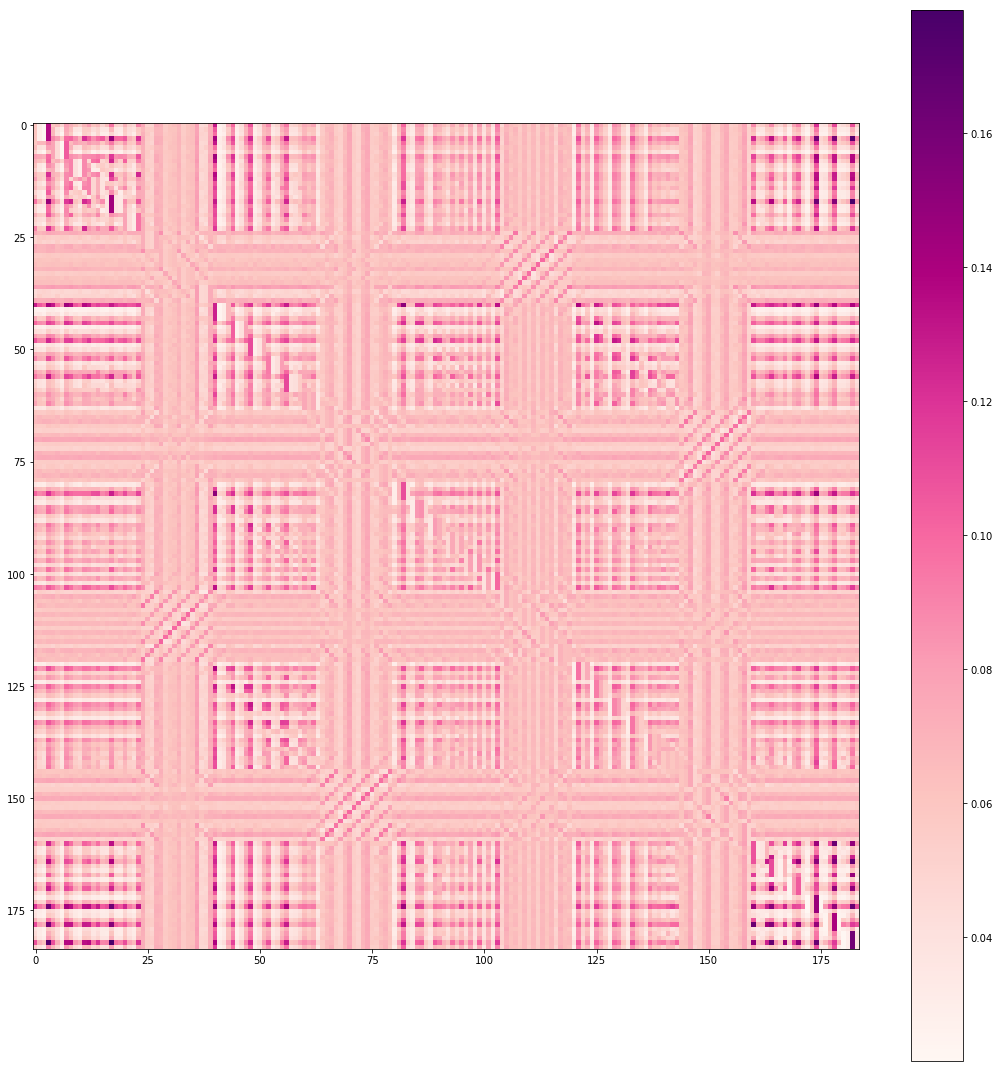

In [21]:
blocklen = np.sqrt(np.product(meanhol_mut2.shape)).astype(int)
S = np.zeros((blocklen, blocklen))
i,j,k,l = meanhol_mut2.shape

for ii in range(i):
    for jj in range(j):
        for kk in range(k):
            for ll in range(l):
                S[(4*ii)+kk, (4*jj)+ll] = meanhol_mut2[ii,jj,kk,ll]

plt.figure(figsize=(15,15))
plt.imshow(S,  cmap='RdPu')
plt.colorbar()